In [10]:
#Loading of the necessary libraries
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
#will give your pc a unique id stored in config.txt, please do not remove this file once created
from library.get_id import get_or_create_unique_id

my_id = get_or_create_unique_id()
print("my ID:", my_id)

In [ ]:
#will try and get the most appropriate device for training
from library.get_device import get_device

device = get_device(no_print=False)

In [ ]:
#Data preprocessing & augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#Data preprocessing & augmentation for testing
test_transform =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#loading of the dataset
data_dir = "./kaggle/input/brain-tumor/4 classes"
dataset = ImageFolder(root=data_dir, transform=train_transform)

In [ ]:
# Split dataset (70-15-15 split)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
#assign the preprocessing to the different sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [ ]:
from library.hyper_parameters import HyperParameters

#Initialize the model, criterion, optimizer:
hyperParameters = HyperParameters()
model = hyperParameters.build_model(device)
criterion = hyperParameters.build_criterion()
optimizer = hyperParameters.build_optimizer(model)

In [ ]:
#assigns the loaders to the sets
train_loader = DataLoader(train_dataset, batch_size=hyperParameters.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=hyperParameters.batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=hyperParameters.batch_size, shuffle=False, num_workers=2)

In [ ]:
#preparing the data: storing the hyperparameters's values
result_init = {
        'computer_id': my_id,
        'learning_rate': hyperParameters.learning_rate,
        'batch_size': hyperParameters.batch_size,
        'epochs': hyperParameters.epochs,
        'dropout': hyperParameters.dropout,
        'optimizer_type': hyperParameters.optimizer_type,
    }

In [ ]:
#preparing the data: training of the model & storing results
from library.training import train_model

results_training = train_model(model, train_loader, val_loader, criterion, optimizer, device, hyperParameters)

In [ ]:
#preparing the data: testing of the model & storing results
from library.evaluation import evaluate

results_evaluation = evaluate(model, test_loader, device)

In [ ]:
#saving the data: storing it in the csv
from library.save_results import save_training_results_to_csv

save_training_results_to_csv(result_init | results_training | results_evaluation)

In [ ]:
from library.auto import automeasure

automeasure(2)

In [ ]:
from library.csv_processing import process_results_csv

process_results_csv()

--- Data Loading: 70 samples loaded ---
-> Outlier Removal: Removed 7 samples (value < 43.28)
-> Transformation: Applying Logit Transform (log(p / (1-p)))

=== MODEL FORMULA ===
logit_test_acc ~ optimizer_type * learning_rate * dropout + I(learning_rate**2) + I(dropout**2)

=== MODEL SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:         logit_test_acc   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     12.76
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           4.30e-10
Time:                        20:59:41   Log-Likelihood:                 5.6147
No. Observations:                  63   AIC:                             6.771
Df Residuals:                      54   BIC:                             26.06
Df Model:                           8                                  

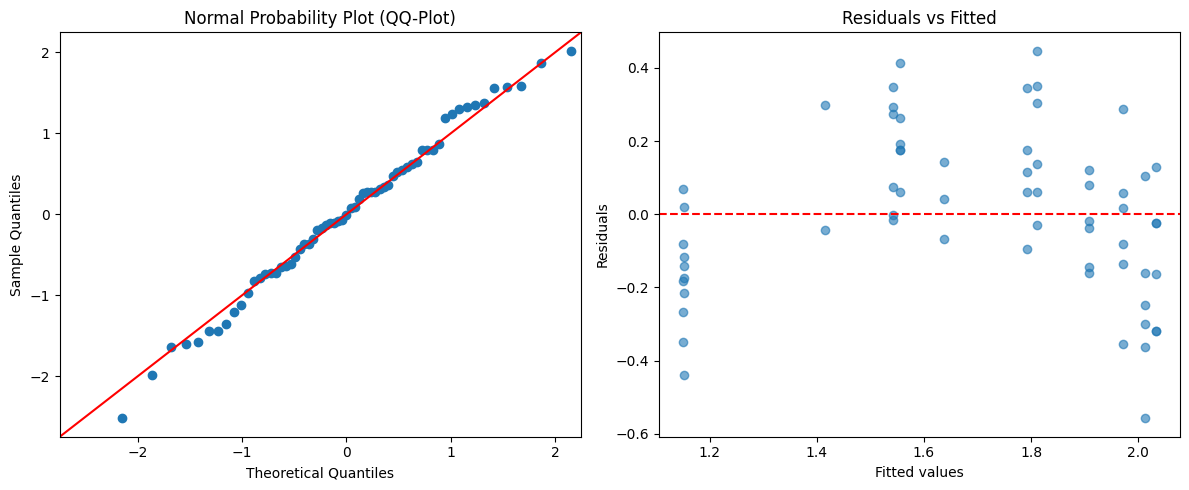

In [1]:
from library.GLM import run_full_glm_analysis

model, anova = run_full_glm_analysis(
    csv_path="cleaned_results.csv",
    response="test_acc",
    factors=["learning_rate", "dropout", "optimizer_type"],
    use_powers=True,        # Ajoute les termes quadratiques (courbes)
    interactions=True,      # Regarde les interactions (ex: LR * Optimizer)
    transform_logit=True,   # ESSENTIEL: Déplie les % pour la normalité
    remove_outliers=True    # ESSENTIEL: Retire les runs ratés
)

NameError: name 'train_losses' is not defined

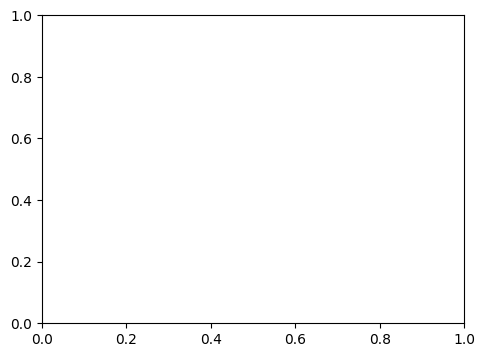

In [6]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()